In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sknetwork.ranking import PageRank
from sknetwork.data import convert_edge_list, load_edge_list

In [2]:
network = "BioPlex3"
disease = "asthma" 


In [3]:
network_files = {
    "BioPlex3": "processed_data/networks/BioPlex3_shared/edges_list_ncbi.csv",
    "HumanNet": "processed_data/networks/HumanNetV3/edges_list_ncbi.csv",
    "PCNet": "processed_data/networks/PCNet/edges_list_ncbi.csv",
    "ProteomeHD": "processed_data/networks/ProteomeHD/edges_list_ncbi.csv",
    "STRING": "processed_data/networks/STRING/edges_list_ncbi.csv",
}

alpha_array = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

# Load Graph

In [4]:
# Load Graph
print("Loading {} graph".format(network))
df = pd.read_csv(network_files[network])[["node1", "node2"]].astype(str)
graph_nodes = set(df["node1"]).union(set(df["node2"]))
edge_list = list(df.itertuples(index=False))
graph = convert_edge_list(edge_list)
node2idx = {n: i for i, n in enumerate(graph.names)}
idx2node = {v: k for k, v in node2idx.items()}
adjacency = graph.adjacency

Loading BioPlex3 graph


In [5]:
df["node2"].dtype

dtype('O')

# Load PEGASUS pvalues

In [12]:
data = pd.read_csv("processed_data/gwas_gene_pvals/{}/filtered_ncbi_PEGASUS_{}_gwas_data.csv".format(disease, disease))
data = data[~data["NCBI_id"].isna()]
data["NCBI_id"] = data["NCBI_id"].astype(str)
min_pval = data["Pvalue"][data["Pvalue"]>0].min()
pegasus_scores = {}
for i, row in data.iterrows():
    pv = np.maximum(min_pval, np.minimum(1, row["Pvalue"]))
    pegasus_scores[row["NCBI_id"]] = np.maximum(0, -np.log10(pv))
pegasus_ncbi_genes = set(pegasus_scores.keys())
ncbi2gene = dict(zip(data.NCBI_id, data.Gene))
# data[data["NCBI_id"].isin(graph["names"])].sort_values(by="Pvalue")
data

,Chr,Gene,nSNPs,Start,Stop,Test-Stat,Pvalue,Error,Best-SNP,SNP-pvalue,NCBI_id
0,1,A3GALT2,68,33772366.0,33786699.0,44.811425,0.574424,1.292712e-14,rs10914692,0.009231,127550
1,1,AADACL3,94,12776117.0,12788726.0,83.344493,0.451577,7.943619e-15,rs3000905,0.052147,126767
2,1,AADACL4,54,12704565.0,12727097.0,39.493893,0.656680,9.349860e-15,rs11121955,0.012345,343066
3,1,ABCA4,261,94458393.0,94586705.0,210.388204,0.688397,3.012240e-15,rs11165076,0.025043,24
4,1,ABCB10,60,229652328.0,229694442.0,41.712991,0.483655,8.694164e-15,rs12734075,0.089851,23456
...,...,...,...,...,...,...,...,...,...,...,...
17147,22,ZNF280A,51,22868060.0,22874613.0,51.315894,0.381351,1.428313e-14,rs2330191,0.065178,129025
17148,22,ZNF280B,51,22838771.0,22863505.0,44.383404,0.457183,9.159330e-15,rs2266984,0.067977,140883
17149,22,ZNF70,58,24083771.0,24093279.0,56.767506,0.415667,6.594791e-15,rs738791,0.070605,7621
17150,22,ZNF74,54,20748479.0,20762752.0,198.180693,0.001879,6.312862e-14,rs1153427,0.000161,7625


In [11]:
data["Pvalue"][data["Pvalue"]>0].min()

2.22e-16

In [10]:
data.sort_values(by="Pvalue")

,Chr,Gene,nSNPs,Start,Stop,Test-Stat,Pvalue,Error,Best-SNP,SNP-pvalue,NCBI_id
11475,13,GPC5,65,92050886.0,93519487.0,1353.588499,0.000000e+00,2.411085e-13,rs16945837,3.956000e-04,2262
13696,17,CSF3,49,38171687.0,38174066.0,2589.590743,2.220000e-16,1.976523e-06,rs3894194,1.060000e-34,1440
7332,8,CSMD1,100,2792874.0,4852328.0,4420.872032,2.220000e-16,2.807426e-08,rs9987349,6.194000e-04,64478
5873,6,HLA-DQA1,67,32605182.0,32611429.0,1832.775592,2.220000e-16,1.086874e-10,rs9272346,2.350000e-28,3117
14129,17,PERLD1,43,37827374.0,37844310.0,3504.825777,2.220000e-16,3.600305e-05,rs2952156,7.550000e-29,93210
...,...,...,...,...,...,...,...,...,...,...,...
7442,8,GOT1L1,124,37791801.0,37797647.0,0.056337,1.000000e+00,1.156796e-14,rs17493462,8.553589e-01,137362
4858,5,ECSM2,358,NaN,NaN,5.701629,1.000000e+00,1.287190e-14,rs7380062,2.181449e-01,641700
4828,5,CTXN3,938,126984712.0,126994322.0,119.077536,1.000000e+00,2.413593e-14,rs248724,3.700310e-02,613212
4829,5,CXCL14,938,134906374.0,134914969.0,77.421845,1.000000e+00,2.298338e-14,rs6868474,7.131850e-02,9547


In [68]:
pagerank_seeds = {}
for node in graph["names"]:
    if node in pegasus_ncbi_genes:
        pagerank_seeds[node2idx[node]] = pegasus_scores[node]
    else:
        pagerank_seeds[node2idx[node]] = 0

seeds_vector = np.array(list(pagerank_seeds.values()))
nonzero_genes = [idx2node[g] for g in pagerank_seeds.keys() if pagerank_seeds[g]>0]
max_val = np.max(seeds_vector[~np.isinf(seeds_vector)])
max_val

4.236521824907804

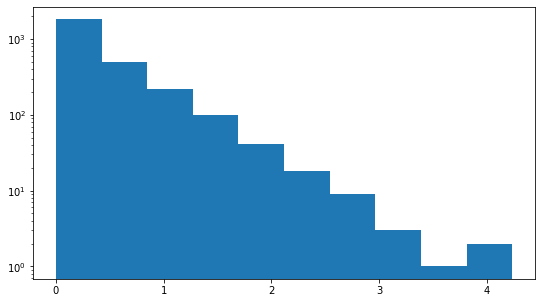

In [69]:
fig, ax = plt.subplots(figsize=(9,5))
ax.hist(pagerank_seeds.values())
ax.set_yscale("log")
plt.show()

# Run RWR 

In [70]:
def process_rwr_results(scores):
    rwr_results = []
    for i, node in enumerate(graph["names"]):
        row = {}

        row["Idx"] = node2idx[node]
        row["Gene NCBI ID"] = node
        row["Symbol"] = ncbi2gene[node] if node in ncbi2gene.keys() else "-"


    #     row[""]
        if node in nonzero_genes:
            init_score = pagerank_seeds[node2idx[node]]
            if np.isinf(init_score):
                init_score = max_val+1
        else:
            init_score = 0

        row["Initial Score"] = init_score
        row["Final Score"] = scores[i]

        rwr_results.append(row)

    rwr_results = pd.DataFrame(rwr_results).sort_values(by="Final Score", ascending=False)
    return rwr_results

In [71]:
for alpha in alpha_array:
    print("Alpha: ", alpha)
    pagerank = PageRank(damping_factor=alpha)
    rwr_scores = pagerank.fit_transform(adjacency, pagerank_seeds)
    rwr_results = process_rwr_results(rwr_scores)
    rwr_results.to_csv("outputs/RWRs_scores/{}_{}_alpha{}_results.csv".format(disease, network, alpha), index=False)
    break

Alpha:  0.1


In [72]:
rwr_results

,Idx,Gene NCBI ID,Symbol,Initial Score,Final Score
2076,2076,84946,LTV1,4.236522,0.003614
1133,1133,5170,PDPK1,4.062033,0.003424
1422,1422,56949,XAB2,3.475228,0.002990
225,225,11325,DDX42,3.239069,0.002819
1733,1733,6599,SMARCC1,3.158412,0.002678
...,...,...,...,...,...
1625,1625,6197,-,0.000000,0.000000
2394,2394,uniprot_P14314-2,-,0.000000,0.000000
2715,2715,uniprot_Q9Y6K9-2,-,0.000000,0.000000
2375,2375,uniprot_O95819-3,-,0.000000,0.000000


In [63]:
(seeds_vector<0).sum()

1

In [65]:
for k, v in pegasus_scores.items():
    if v<0:
        print(k, v)
# pegasus_score

613212 -4.33947359948977e-15
9547 -4.33947359948977e-15
10659 -4.33947359948977e-15
51076 -4.33947359948977e-15
50624 -4.33947359948977e-15
55280 -4.33947359948977e-15
6387 -4.33947359948977e-15
8651 -4.33947359948977e-15
6650 -4.33947359948977e-15
30812 -4.33947359948977e-15


In [66]:
data[data["NCBI_id"]=="613212"]

,Chr,Gene,nSNPs,Start,Stop,Test-Stat,Pvalue,Error,Best-SNP,SNP-pvalue,NCBI_id
4859,5,CTXN3,1260,126984712.0,126994322.0,139.375432,1.0,2.442232e-14,rs248724,0.06743,613212
